ChatGPT was used for generation of basic code snippets and code formatting.

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, AutoMinorLocator
from matplotlib.lines import Line2D
import scipy
from pybaselines import Baseline
from scipy.optimize import curve_fit
from scipy.special import wofz
import scipy.signal

In [2]:
def find_data_start(filepath):
    """
    Finds the line index where the data starts in a file.

    Parameters:
    - filepath: Path to the file.

    Returns:
    - i: Line index where the data starts, or None if not found.
    """
    with open(filepath, 'r') as file:
        for i, line in enumerate(file):
            try:
                # Try to convert the first part of the line to a float
                float(line.split()[0])
                return i
            except:
                continue
    return None

def extract_number(filename):
    """
    Extracts the last number from the filename assuming it contains at least three numbers.

    Parameters:
    - filename: Name of the file.

    Returns:
    - The last number found in the filename.

    Raises:
    - ValueError: If the filename does not contain at least three numbers.
    """
    regex = re.compile(r'\d+')
    numbers = [int(x) for x in regex.findall(filename)]
    if len(numbers) >= 3:
        return numbers[-1]
    else:
        raise ValueError("The filename does not contain at least three numbers.")

def process_raw_data(directory):
    """
    Processes raw data files in a directory and combines them into a sorted DataFrame.

    Parameters:
    - directory: Directory containing the raw data files.

    Returns:
    - sorted_combined_df: DataFrame with combined and sorted data.
    """
    data_dict = {}
    x_values = None

    for filename in os.listdir(directory):
        if filename.endswith('.txt') or filename.endswith('.asc'):
            file_path = os.path.join(directory, filename)

            start_line = find_data_start(file_path)

            if start_line is not None:
                df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['x', 'y'], skiprows=start_line)

                if x_values is None:
                    x_values = df['x'].values

                data_dict[filename] = df['y'].values
            else:
                print(f"Could not find data start in file: {filename}")

    y_df = pd.DataFrame(data_dict)
    x_df = pd.DataFrame({'x': x_values})
    combined_df = pd.concat([x_df, y_df], axis=1)
    sorted_columns = sorted(combined_df.columns[1:], key=extract_number)
    sorted_columns = ['x'] + sorted_columns
    sorted_combined_df = combined_df[sorted_columns]

    return sorted_combined_df


In [3]:
def plot_baseline_corrected_data(
    df, 
    x_col, 
    y_col, 
    lambda_param=10**7, 
    p_param=0.5, 
    n_iter=100, 
    order_polynomial=2, 
    xlabel=r'$\tilde{\nu}$ (cm$^{-1}$)',
    ylabel='Intensity (a.u.)',
    plot_title=None,
    show_legend=True,
    legend_location='center left',
    bbox_anchor=(1, 0.5),
    x_limits=None,
    y_limits=None,
    save_path=None
):
    """
    Plots baseline-corrected data using asymmetric least squares smoothing.

    Parameters:
    - df: DataFrame containing the data.
    - x_col: Column name for x data.
    - y_col: Column name for y data.
    - lambda_param: Smoothing parameter for the baseline correction.
    - p_param: Asymmetry parameter for the baseline correction.
    - n_iter: Number of iterations for the baseline correction.
    - order_polynomial: Order of the difference polynomial.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - plot_title: Title of the plot (optional).
    - show_legend: Whether to show the legend.
    - legend_location: Location of the legend.
    - bbox_anchor: Anchor point for the legend.
    - x_limits: Tuple to set x-axis limits (optional).
    - y_limits: Tuple to set y-axis limits (optional).
    - save_path: Path to save the plot (optional).
    """
    df = df.sort_values(by=x_col)
    baseline_fitter = Baseline(x_data=df[x_col])
    baseline = baseline_fitter.asls(
        df[y_col].to_numpy(),
        lambda_=lambda_param,
        p=p_param,
        max_iter=n_iter,
        diff_order=order_polynomial
    )[0]

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(8)

    plt.scatter(df[x_col], baseline, label='baseline', color='darkred', alpha=0.7, marker='x', s=2)
    plt.scatter(df[x_col], df[y_col], label=y_col + ' raw', color='lightgrey', alpha=0.5, marker='x', s=2)

    ax.set_xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks([])  # Hide y-axis numbers
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_tick_params(which='major', length=7, width=1.5, direction='inout')
    ax.xaxis.set_tick_params(which='minor', length=4, width=1.5, direction='inout')

    secax = ax.secondary_xaxis('top')
    secax.xaxis.set_major_locator(AutoLocator())
    secax.xaxis.set_minor_locator(AutoMinorLocator())
    secax.xaxis.set_tick_params(which='major', length=7, width=1.5, direction='in', labelbottom=False)
    secax.xaxis.set_tick_params(which='minor', length=4, width=1.5, direction='in', labelbottom=False)
    secax.xaxis.set_ticklabels([])

    if x_limits:
        ax.set_xlim(x_limits)
    if y_limits:
        ax.set_ylim(y_limits)
    
    ax.grid(False)

    if show_legend:
        plt.legend(loc=legend_location, bbox_to_anchor=bbox_anchor, frameon=False)

    if plot_title:
        plt.title(plot_title)

    if save_path:
        plt.savefig(save_path, dpi=1200, bbox_inches='tight')

    plt.show()

In [4]:
def do_baseline_correction(df):
    """
    Applies baseline correction to each column in the DataFrame (excluding 'x' columns).

    Parameters:
    - df: DataFrame containing the data.
    - lambda_param: Smoothing parameter for the baseline correction.
    - p_param: Asymmetry parameter for the baseline correction.
    - n_iter: Number of iterations for the baseline correction.
    - order_polynomial: Order of the difference polynomial.

    Returns:
    - baseline_corr_df: DataFrame with baseline-corrected data.
    """
    baseline_corr_df = pd.DataFrame()
    baseline_corr_df['x'] = df['x']
    baseline_fitter = Baseline(x_data=df['x'])  # Assuming 'x' column is present in the DataFrame

    for column in df.columns:
        if 'x' in column:
            continue
        else:
            data = df[column].to_numpy()
            baseline = baseline_fitter.asls(
                data
            )[0]

            baseline_corrected_y = data - baseline
            baseline_corr_df['baseline_corr_' + column] = baseline_corrected_y

    return baseline_corr_df

In [5]:
def smooth_and_normalize_data(df, length_window=5, order_polynomial=2):
    """
    Smooths and normalizes the columns in the DataFrame using the Savitzky-Golay filter.

    Parameters:
    - df: DataFrame containing the data to be smoothed and normalized.
    - length_window: Window length for the Savitzky-Golay filter.
    - order_polynomial: Polynomial order for the Savitzky-Golay filter.

    Returns:
    - smoothed_df: DataFrame with smoothed and normalized data.
    """
    smoothed_df = pd.DataFrame()
    smoothed_df['x'] = df['x']  # Preserve the x column

    for column in df.columns:
        if column == 'x':
            continue
        
        # Apply Savitzky-Golay smoothing
        smoothed_y = scipy.signal.savgol_filter(df[column], length_window, order_polynomial)
        
        # Normalize the smoothed data
        norm_y = (smoothed_y - np.min(smoothed_y)) / (np.max(smoothed_y) - np.min(smoothed_y))
        smoothed_df[column] = norm_y
    
    return smoothed_df

In [6]:
def find_peaks_in_smoothed_data(smoothed_df, x_data, name, height_threshold=0.8):
    """
    Identifies peaks in smoothed data and returns their positions.

    Parameters:
    - smoothed_df: DataFrame containing the smoothed data.
    - x_data: Series or array representing the x-axis data.
    - name: Name of the column to analyze in the smoothed data.
    - height_threshold: Minimum height required for a peak.

    Returns:
    - peak_positions: Array of x-axis positions where peaks are found.
    - peaks_indices: Indices of the peaks in the y_data.
    - peak_heights: Heights of the identified peaks.
    """
    
    # Construct column names for smoothed and baseline-corrected data
    name_smooth = 'smoothed_baseline_corr_' + name
    
    # name_baseline = 'baseline_corr_' + name

    # Extract y_data from the smoothed DataFrame
    y_data = smoothed_df[name_smooth].to_numpy()

    # Find peaks in the smoothed data
    peaks_indices, properties = scipy.signal.find_peaks(y_data, height=height_threshold)
    peak_heights = properties['peak_heights']

    # Get the x-axis positions of the identified peaks
    peak_positions = x_data.iloc[peaks_indices].to_numpy()

    return peak_positions, peaks_indices, peak_heights

In [7]:
def fit_voigt_to_spectra(smoothed_df, x_data, expected_pos, tolerance, window_size=500, peak_widths=15):
    """
    Fits Voigt profiles to peaks in the provided spectra.

    Parameters:
    - smoothed_df: DataFrame containing smoothed spectral data.
    - x_data: Array-like, x-axis data corresponding to the spectra.
    - expected_pos: Expected position of the peaks for filtering.
    - tolerance: Allowed deviation from the expected peak position.
    - window_size: Window size for fitting intervals around each peak.

    Returns:
    - fit_results: Dictionary with columns as keys and a list of optimal fitting parameters for each peak as values.
    """

    def voigt(x, amplitude, center, sigma, gamma):
        """Voigt profile function for fitting."""
        z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
        return amplitude * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

    fit_results = {}

    for column in smoothed_df.columns:
        if column == 'x':
            print("Skipping 'x' column.")
            continue
        
        column_fit_params = []
      
        y_data = smoothed_df[column].to_numpy()
        peaks, _ = scipy.signal.find_peaks(y_data, height=0.8)
        peak_positions = x_data[peaks].to_numpy()

        for peak in peak_positions:
            if abs(peak - expected_pos) <= tolerance:
                print(f"Processing {column}: Peak position {peak} is within tolerance range of expected position {expected_pos}.")

                # Define fitting range around the peak
                min_index = np.searchsorted(x_data, peak - window_size // 2)
                max_index = np.searchsorted(x_data, peak + window_size // 2)
                
                if min_index < 0:
                    min_index = 0
                if max_index > len(x_data):
                    max_index = len(x_data)
                
                x_fit = x_data[min_index:max_index]
                y_fit = y_data[min_index:max_index]
            
                # Initial guess for Voigt parameters: [amplitude, center, sigma, gamma]
                initial_guess_voigt = [np.max(y_fit), peak, 0.5, 0.1]
        
                try:
                    # Fit the Voigt profile to the data
                    popt_voigt, _ = curve_fit(voigt, x_fit, y_fit, p0=initial_guess_voigt, maxfev=16000)
                    column_fit_params.append(popt_voigt)
                    
                except Exception as e:
                    print(f'Error fitting peak at position {peak} in {column}: {e}')
                    continue
                
            else:
                print(f"Skipping {column}: Peak position {peak} is outside tolerance range of expected position {expected_pos}.")

        # Store the fit parameters for this column
        fit_results[column] = column_fit_params

    return fit_results

In [8]:
def get_center_positions(fit_results):
    """
    Extracts the center positions of the last fitted peak in each spectrum.

    Parameters:
    - fit_results: Dictionary where each key corresponds to a spectrum, and the value is a list of fitted parameters.

    Returns:
    - center_positions: List of center positions for the last fitted peak in each spectrum.
    """
    center_positions = []

    for spectrum in fit_results:
        # Append the center position (index 1) of the last fitted peak
        center_positions.append(fit_results[spectrum][-1][1])

    return center_positions

In [9]:
def calculate_relative_peak_shifts(center_positions):
    """
    Calculates the relative peak positions with respect to the first peak in the list.

    Parameters:
    - center_positions: List of center positions.

    Returns:
    - relative_shifts: List of relative peak shifts.
    """
    relative_shifts = []

    reference_position = center_positions[0]  # The position of the first peak is used as the reference
    for position in center_positions:
        # Calculate the relative shift with respect to the reference position
        relative_shifts.append(position - reference_position)

    return relative_shifts

In [10]:
def get_applied_potentials(max_potential, min_potential):
    """
    Generates an array of applied potentials based on a predefined pattern.

    Parameters:
    - max_potential: the maximum potential that was applied
    - min_potential: the minimum potential that was applied

    Returns:
    - applied_potentials: List of integers representing the applied potentials.
    """

    potentials = list(range(0, 1))
    potentials += list(range(400, -401, -100))
    potentials += list(range(0, 1))
    
    return potentials


In [11]:
def truncate_to_shortest_array(arrays, min_expected_length=None):
    """
    Truncates all input arrays to the length of the shortest array.

    Parameters:
    - arrays: List of arrays (lists) to be truncated.
    - min_expected_length: Minimum expected length for the arrays. If any array is shorter, raise an error.

    Returns:
    - truncated_arrays: List of truncated arrays.

    Raises:
    - ValueError: If the shortest array is shorter than the min_expected_length.
    """
    # Find the length of the shortest array
    min_length = min(len(arr) for arr in arrays)
    
    # Check if the shortest array meets the minimum expected length
    if min_expected_length is not None and min_length < min_expected_length:
        raise ValueError(f"Error: The shortest array length ({min_length}) is less than the expected minimum length ({min_expected_length}).")

    # Truncate all arrays to the length of the shortest array
    truncated_arrays = [arr[:min_length] for arr in arrays]

    return truncated_arrays

In [12]:
def calculate_error_bars(rel_peak_shift_spot1, rel_peak_shift_spot2, rel_peak_shift_spot3):
    """
    Calculates the mean values and error bars (standard deviation) for relative peak shifts.

    Parameters:
    - rel_peak_shift_spot1: List of relative peak shifts for spot 1.
    - rel_peak_shift_spot2: List of relative peak shifts for spot 2.
    - rel_peak_shift_spot3: List of relative peak shifts for spot 3.

    Returns:
    - mean_values: List of mean values for each index across the three spots.
    - error_bars: List of standard deviations (error bars) for each index across the three spots.
    """
    mean_values = []
    error_bars = []

    # Calculate mean values and error bars for each index
    for i in range(len(rel_peak_shift_spot1)):
        values = [rel_peak_shift_spot1[i], rel_peak_shift_spot2[i], rel_peak_shift_spot3[i]]
        mean_values.append(np.mean(values))
        error_bars.append(np.std(values))

    return mean_values, error_bars

In [13]:
def create_linear_fit_and_plot(x_val, y_val, y_err, errbar_marker, errbar_maincol, name, font_size):
    """
    Fits a linear model to the data with error bars, and plots the result.

    Parameters:
    - x_val: Array-like, the x values of the data.
    - y_val: Array-like, the y values of the data.
    - y_err: Array-like, the error values for the y data.
    """
    
    def linear_func(x, m, c):
        return m * x + c

    # Perform the linear fit
    popt, pcov = curve_fit(
        linear_func,
        x_val,
        y_val,
        sigma=y_err,
        absolute_sigma=True,
        maxfev=16000
    )
    slope, intercept = popt
    slope_err, intercept_err = np.sqrt(np.diag(pcov))

    # Calculate R-squared
    residuals = y_val - linear_func(x_val, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_val - np.mean(y_val))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot setup
    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(8)

    # Error bars plot
    plt.errorbar(
        x_val,
        y_val,
        yerr=y_err,
        fmt='x',
        markerfacecolor='white',
        marker=errbar_marker,
        ecolor=errbar_maincol,
        capsize=2,
        color=errbar_maincol,
        alpha=1.0,
        markersize=5
    )

    # Linear fit plot
    plt.plot(
        x_val,
        linear_func(x_val, *popt),
        label=f"Linear regression: \n y = ({slope * 1000:.1f} ± {slope_err * 1000:.1f})" r" $\cdot$ $10^{-3}$ $\Phi$" f" + ({intercept:.2f} ± {intercept_err:.2f}), \n $r^2$ = {r_squared:.5f}",
        color=errbar_maincol,
        linestyle='solid',
        alpha = 0.3
    )

    # Set plot layout
    ax.set_xlabel(r'$\mathit{\Phi}$ vs. Ag/AgCl (mV)', fontsize=font_size)
    ax.set_ylabel(r'$\Delta$$\tilde{\nu}$ (cm$^{-1}$)', fontsize=font_size)
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # Set x-axis ticks
    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_tick_params(which='major', length=7, width=1.5, direction='in', labelsize=font_size)
    ax.xaxis.set_tick_params(which='minor', length=4, width=1.5, direction='in', labelsize=font_size)

    # Add secondary x-axis on top with only inside ticks
    secax = ax.secondary_xaxis('top')
    secax.xaxis.set_major_locator(AutoLocator())
    secax.xaxis.set_minor_locator(AutoMinorLocator())
    secax.xaxis.set_tick_params(which='major', length=7, width=1.5, direction='in', labelbottom=False, labelsize=font_size)
    secax.xaxis.set_tick_params(which='minor', length=4, width=1.5, direction='in', labelbottom=False, labelsize=font_size)
    secax.xaxis.set_ticklabels([])

    # Set y-axis ticks
    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_tick_params(which='major', length=7, width=1.5, direction='in', labelsize=font_size)
    ax.yaxis.set_tick_params(which='minor', length=4, width=1.5, direction='in', labelsize=font_size)

    # Add secondary y-axis on right with only inside ticks
    secay = ax.secondary_yaxis('right')
    secay.yaxis.set_major_locator(AutoLocator())
    secay.yaxis.set_minor_locator(AutoMinorLocator())
    secay.yaxis.set_tick_params(which='major', length=7, width=1.5, direction='in', labelbottom=False, labelsize=font_size)
    secay.yaxis.set_tick_params(which='minor', length=4, width=1.5, direction='in', labelbottom=False, labelsize=font_size)
    secay.yaxis.set_ticklabels([])

    # Set y-axis limits and remove grid
    ax.set_ylim([-4, 3.5])
    ax.grid(False)

    # Set legend settings
    plt.legend(
        loc='upper left',
        frameon=True
    )

    custom_legend = [Line2D([0], [0], color='none', label=f"Linear Regression (y = $m \cdot \Phi$): \n$m$ = ({slope * 1000:.1f} ± {slope_err * 1000:.1f})" r" cm$^{-1}$ V$^{-1}$" f", \n$r^2$ = {r_squared:.3f}")]

    # Add custom legend
    plt.legend(handles=custom_legend, loc='upper left', bbox_to_anchor=(0.100, 0.975), frameon=False, handlelength=0, handletextpad=0, fontsize=font_size)

    plt.savefig(name, dpi=1200, bbox_inches='tight')
    plt.show()

<>:112: SyntaxWarning: invalid escape sequence '\c'
<>:112: SyntaxWarning: invalid escape sequence '\c'
C:\Users\jw3\AppData\Local\Temp\ipykernel_33168\1281313576.py:112: SyntaxWarning: invalid escape sequence '\c'
  custom_legend = [Line2D([0], [0], color='none', label=f"Linear Regression (y = $m \cdot \Phi$): \n$m$ = ({slope * 1000:.1f} ± {slope_err * 1000:.1f})" r" cm$^{-1}$ V$^{-1}$" f", \n$r^2$ = {r_squared:.3f}")]


In [14]:
directory_spot1_4mbn = 'path/to/dir/4-mbn/spot1'
directory_spot2_4mbn = 'path/to/dir/4-mbn/spot2'
directory_spot3_4mbn = 'path/to/dir/4-mbn/spot3'

directory_spot1_3mbn = 'path/to/dir/3-mbn/spot1'
directory_spot2_3mbn = 'path/to/dir/3-mbn/spot2'
directory_spot3_3mbn = 'path/to/dir/3-mbn/spot3'

directory_spot1_35mbn = 'path/to/dir/35-dmbn/spot1'
directory_spot2_35mbn = 'path/to/dir/35-dmbn/spot2'
directory_spot3_35mbn = 'path/to/dir/35-dmbn/spot3'

directory_spot1_34mbn = 'path/to/dir/34-dmbn/spot1'
directory_spot2_34mbn = 'path/to/dir/34-dmbn/spot2'
directory_spot3_34mbn = 'path/to/dir/34-dmbn/spot3'

In [15]:
sorted_combined_df_spot1_4mbn = process_raw_data(directory_spot1_4mbn)
sorted_combined_df_spot2_4mbn = process_raw_data(directory_spot2_4mbn)
sorted_combined_df_spot3_4mbn = process_raw_data(directory_spot3_4mbn)

sorted_combined_df_spot1_3mbn = process_raw_data(directory_spot1_3mbn)
sorted_combined_df_spot2_3mbn = process_raw_data(directory_spot2_3mbn)
sorted_combined_df_spot3_3mbn = process_raw_data(directory_spot3_3mbn)

sorted_combined_df_spot1_35mbn = process_raw_data(directory_spot1_35mbn)
sorted_combined_df_spot2_35mbn = process_raw_data(directory_spot2_35mbn)
sorted_combined_df_spot3_35mbn = process_raw_data(directory_spot3_35mbn)

sorted_combined_df_spot1_34mbn = process_raw_data(directory_spot1_34mbn)
sorted_combined_df_spot2_34mbn = process_raw_data(directory_spot2_34mbn)
sorted_combined_df_spot3_34mbn = process_raw_data(directory_spot3_34mbn)

C:\Users\jw3\AppData\Local\Temp\ipykernel_33168\2818331170.py:61: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['x', 'y'], skiprows=start_line)
C:\Users\jw3\AppData\Local\Temp\ipykernel_33168\2818331170.py:61: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['x', 'y'], skiprows=start_line)
C:\Users\jw3\AppData\Local\Temp\ipykernel_33168\2818331170.py:61: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['x', 'y'], skiprows=start_line)
C:\Users\jw3\AppData\Local\Temp\ipykernel_33168\2818331170.py

In [16]:
baseline_corr_df_spot1_4mbn = do_baseline_correction(sorted_combined_df_spot1_4mbn)
baseline_corr_df_spot2_4mbn = do_baseline_correction(sorted_combined_df_spot2_4mbn)
baseline_corr_df_spot3_4mbn = do_baseline_correction(sorted_combined_df_spot3_4mbn)

baseline_corr_df_spot1_3mbn = do_baseline_correction(sorted_combined_df_spot1_3mbn)
baseline_corr_df_spot2_3mbn = do_baseline_correction(sorted_combined_df_spot2_3mbn)
baseline_corr_df_spot3_3mbn = do_baseline_correction(sorted_combined_df_spot3_3mbn)

baseline_corr_df_spot1_35mbn = do_baseline_correction(sorted_combined_df_spot1_35mbn)
baseline_corr_df_spot2_35mbn = do_baseline_correction(sorted_combined_df_spot2_35mbn)
baseline_corr_df_spot3_35mbn = do_baseline_correction(sorted_combined_df_spot3_35mbn)

baseline_corr_df_spot1_34mbn = do_baseline_correction(sorted_combined_df_spot1_34mbn)
baseline_corr_df_spot2_34mbn = do_baseline_correction(sorted_combined_df_spot2_34mbn)
baseline_corr_df_spot3_34mbn = do_baseline_correction(sorted_combined_df_spot3_34mbn)

In [17]:
smoothed_spot1_4mbn = smooth_and_normalize_data(baseline_corr_df_spot1_4mbn)
smoothed_spot2_4mbn = smooth_and_normalize_data(baseline_corr_df_spot2_4mbn)
smoothed_spot3_4mbn = smooth_and_normalize_data(baseline_corr_df_spot3_4mbn)

smoothed_spot1_3mbn = smooth_and_normalize_data(baseline_corr_df_spot1_3mbn)
smoothed_spot2_3mbn = smooth_and_normalize_data(baseline_corr_df_spot2_3mbn)
smoothed_spot3_3mbn = smooth_and_normalize_data(baseline_corr_df_spot3_3mbn)

smoothed_spot1_35mbn = smooth_and_normalize_data(baseline_corr_df_spot1_35mbn)
smoothed_spot2_35mbn = smooth_and_normalize_data(baseline_corr_df_spot2_35mbn)
smoothed_spot3_35mbn = smooth_and_normalize_data(baseline_corr_df_spot3_35mbn)

smoothed_spot1_34mbn = smooth_and_normalize_data(baseline_corr_df_spot1_34mbn)
smoothed_spot2_34mbn = smooth_and_normalize_data(baseline_corr_df_spot2_34mbn)
smoothed_spot3_34mbn = smooth_and_normalize_data(baseline_corr_df_spot3_34mbn)

In [18]:
%%capture captured_output

fit_results_spot1_4mbn = fit_voigt_to_spectra(smoothed_spot1_4mbn, sorted_combined_df_spot1_4mbn['x'], expected_pos=2220, tolerance=50)
fit_results_spot2_4mbn = fit_voigt_to_spectra(smoothed_spot2_4mbn, sorted_combined_df_spot1_4mbn['x'], expected_pos=2220, tolerance=50)
fit_results_spot3_4mbn = fit_voigt_to_spectra(smoothed_spot3_4mbn, sorted_combined_df_spot1_4mbn['x'], expected_pos=2220, tolerance=50)

fit_results_spot1_3mbn = fit_voigt_to_spectra(smoothed_spot1_3mbn, sorted_combined_df_spot1_3mbn['x'], expected_pos=2220, tolerance=50)
fit_results_spot2_3mbn = fit_voigt_to_spectra(smoothed_spot2_3mbn, sorted_combined_df_spot1_3mbn['x'], expected_pos=2220, tolerance=50)
fit_results_spot3_3mbn = fit_voigt_to_spectra(smoothed_spot3_3mbn, sorted_combined_df_spot1_3mbn['x'], expected_pos=2220, tolerance=50)

fit_results_spot1_35mbn = fit_voigt_to_spectra(smoothed_spot1_35mbn, sorted_combined_df_spot1_35mbn['x'], expected_pos=2220, tolerance=50)
fit_results_spot2_35mbn = fit_voigt_to_spectra(smoothed_spot2_35mbn, sorted_combined_df_spot1_35mbn['x'], expected_pos=2220, tolerance=50)
fit_results_spot3_35mbn = fit_voigt_to_spectra(smoothed_spot3_35mbn, sorted_combined_df_spot1_35mbn['x'], expected_pos=2220, tolerance=50)

fit_results_spot1_34mbn = fit_voigt_to_spectra(smoothed_spot1_34mbn, sorted_combined_df_spot1_34mbn['x'], expected_pos=2220, tolerance=50)
fit_results_spot2_34mbn = fit_voigt_to_spectra(smoothed_spot2_34mbn, sorted_combined_df_spot1_34mbn['x'], expected_pos=2220, tolerance=50)
fit_results_spot3_34mbn = fit_voigt_to_spectra(smoothed_spot3_34mbn, sorted_combined_df_spot1_34mbn['x'], expected_pos=2220, tolerance=50)

In [19]:
center_positions_spot1_4mbn = get_center_positions(fit_results_spot1_4mbn)
center_positions_spot2_4mbn = get_center_positions(fit_results_spot2_4mbn)
center_positions_spot3_4mbn = get_center_positions(fit_results_spot3_4mbn)

center_positions_spot1_3mbn = get_center_positions(fit_results_spot1_3mbn)
center_positions_spot2_3mbn = get_center_positions(fit_results_spot2_3mbn)
center_positions_spot3_3mbn = get_center_positions(fit_results_spot3_3mbn)

center_positions_spot1_35mbn = get_center_positions(fit_results_spot1_35mbn)
center_positions_spot2_35mbn = get_center_positions(fit_results_spot2_35mbn)
center_positions_spot3_35mbn = get_center_positions(fit_results_spot3_35mbn)

center_positions_spot1_34mbn = get_center_positions(fit_results_spot1_34mbn)
center_positions_spot2_34mbn = get_center_positions(fit_results_spot2_34mbn)
center_positions_spot3_34mbn = get_center_positions(fit_results_spot3_34mbn)

In [20]:
applied_potentials = get_applied_potentials(400,-400)

In [21]:
relative_peak_shifts_spot1_4mbn = calculate_relative_peak_shifts(center_positions_spot1_4mbn)
relative_peak_shifts_spot2_4mbn = calculate_relative_peak_shifts(center_positions_spot2_4mbn)
relative_peak_shifts_spot3_4mbn = calculate_relative_peak_shifts(center_positions_spot3_4mbn)

relative_peak_shifts_spot1_3mbn = calculate_relative_peak_shifts(center_positions_spot1_3mbn)
relative_peak_shifts_spot2_3mbn = calculate_relative_peak_shifts(center_positions_spot2_3mbn)
relative_peak_shifts_spot3_3mbn = calculate_relative_peak_shifts(center_positions_spot3_3mbn)

relative_peak_shifts_spot1_35mbn = calculate_relative_peak_shifts(center_positions_spot1_35mbn)
relative_peak_shifts_spot2_35mbn = calculate_relative_peak_shifts(center_positions_spot2_35mbn)
relative_peak_shifts_spot3_35mbn = calculate_relative_peak_shifts(center_positions_spot3_35mbn)

relative_peak_shifts_spot1_34mbn = calculate_relative_peak_shifts(center_positions_spot1_34mbn)
relative_peak_shifts_spot2_34mbn = calculate_relative_peak_shifts(center_positions_spot2_34mbn)
relative_peak_shifts_spot3_34mbn = calculate_relative_peak_shifts(center_positions_spot3_34mbn)

list_of_arrays_4mbn = [
    relative_peak_shifts_spot1_4mbn,
    relative_peak_shifts_spot2_4mbn,
    relative_peak_shifts_spot3_4mbn
]

list_of_arrays_3mbn = [
    relative_peak_shifts_spot1_3mbn,
    relative_peak_shifts_spot2_3mbn,
    relative_peak_shifts_spot3_3mbn
]

list_of_arrays_35mbn = [
    relative_peak_shifts_spot1_35mbn,
    relative_peak_shifts_spot2_35mbn,
    relative_peak_shifts_spot3_35mbn
]

list_of_arrays_34mbn = [
    relative_peak_shifts_spot1_34mbn,
    relative_peak_shifts_spot2_34mbn,
    relative_peak_shifts_spot3_34mbn
]

In [22]:
truncated_arrays_4mbn = truncate_to_shortest_array(list_of_arrays_4mbn)
truncated_arrays_3mbn = truncate_to_shortest_array(list_of_arrays_3mbn)
truncated_arrays_35mbn = truncate_to_shortest_array(list_of_arrays_35mbn)
truncated_arrays_34mbn = truncate_to_shortest_array(list_of_arrays_34mbn)

relative_peak_shifts_spot1_4mbn, relative_peak_shifts_spot2_4mbn, relative_peak_shifts_spot3_4mbn = truncated_arrays_4mbn
relative_peak_shifts_spot1_3mbn, relative_peak_shifts_spot2_3mbn, relative_peak_shifts_spot3_3mbn = truncated_arrays_3mbn
relative_peak_shifts_spot1_35mbn, relative_peak_shifts_spot2_35mbn, relative_peak_shifts_spot3_35mbn = truncated_arrays_35mbn
relative_peak_shifts_spot1_34mbn, relative_peak_shifts_spot2_34mbn, relative_peak_shifts_spot3_34mbn = truncated_arrays_34mbn

In [23]:
mean_values_4mbn, error_bars_4mbn = calculate_error_bars(
    relative_peak_shifts_spot1_4mbn,
    relative_peak_shifts_spot2_4mbn,
    relative_peak_shifts_spot3_4mbn
)

mean_values_3mbn, error_bars_3mbn = calculate_error_bars(
    relative_peak_shifts_spot1_3mbn,
    relative_peak_shifts_spot2_3mbn,
    relative_peak_shifts_spot3_3mbn
)

mean_values_35mbn, error_bars_35mbn = calculate_error_bars(
    relative_peak_shifts_spot1_35mbn,
    relative_peak_shifts_spot2_35mbn,
    relative_peak_shifts_spot3_35mbn
)

mean_values_34mbn, error_bars_34mbn = calculate_error_bars(
    relative_peak_shifts_spot1_34mbn,
    relative_peak_shifts_spot2_34mbn,
    relative_peak_shifts_spot3_34mbn
)

In [24]:
x_val_4mbn = np.array(applied_potentials[1:10])
y_val_4mbn = np.array(mean_values_4mbn[1:10])
y_err_4mbn = np.array(error_bars_4mbn[1:10])

x_val_3mbn = np.array(applied_potentials[1:10])
y_val_3mbn = np.array(mean_values_3mbn[1:10])
y_err_3mbn = np.array(error_bars_3mbn[1:10])

x_val_35mbn = np.array(applied_potentials[1:10])
y_val_35mbn = np.array(mean_values_35mbn[1:10])
y_err_35mbn = np.array(error_bars_35mbn[1:10])

x_val_34mbn = np.array(applied_potentials[1:10])
y_val_34mbn = np.array(mean_values_34mbn[1:10])
y_err_34mbn = np.array(error_bars_34mbn[1:10])

C:\Users\jw3\AppData\Local\Temp\ipykernel_33168\1281313576.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.errorbar(


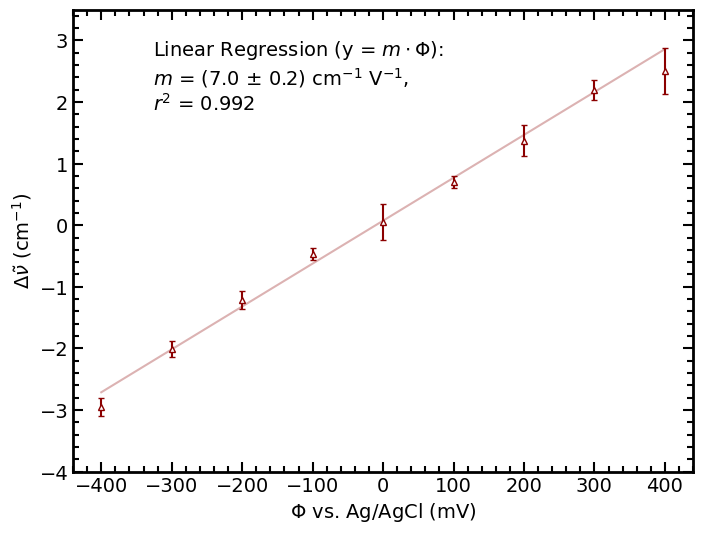

C:\Users\jw3\AppData\Local\Temp\ipykernel_33168\1281313576.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.errorbar(


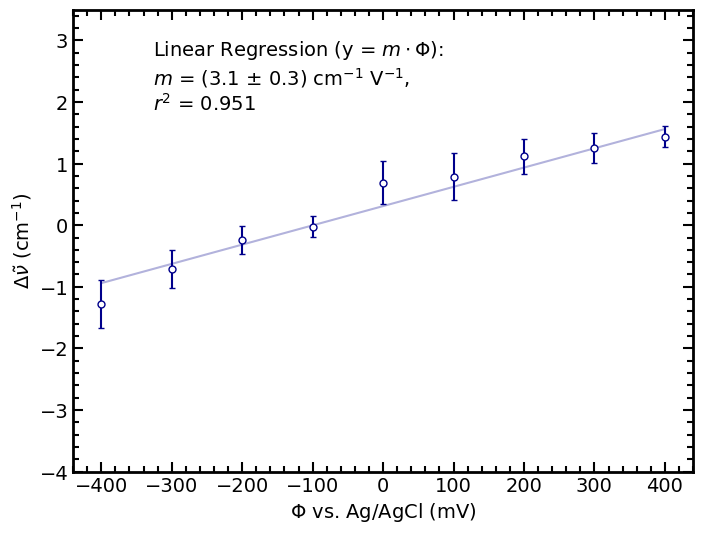

C:\Users\jw3\AppData\Local\Temp\ipykernel_33168\1281313576.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.errorbar(


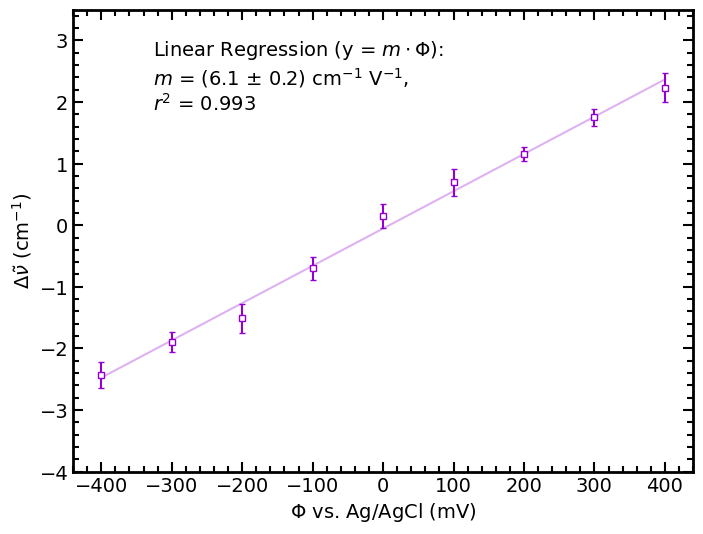

C:\Users\jw3\AppData\Local\Temp\ipykernel_33168\1281313576.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.errorbar(


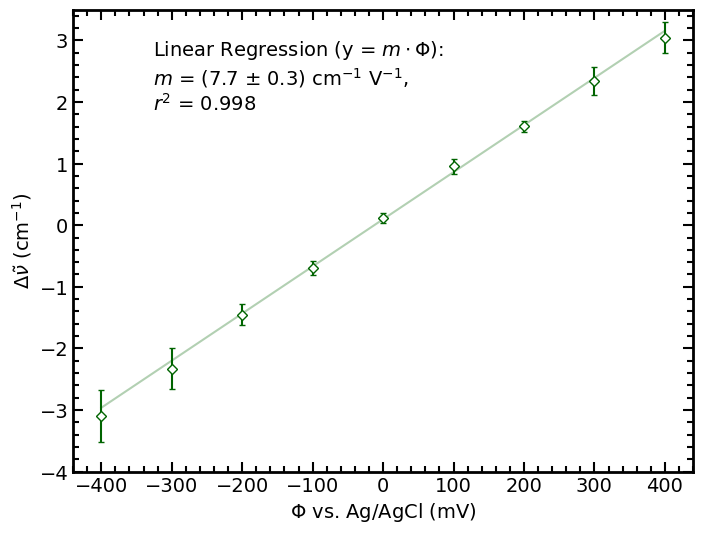

In [25]:
errbar_marker_4mbn = '^'
errbar_maincol_4mbn = 'darkred'
name_4mbn = 'eie_results_4mbn.png'

errbar_marker_3mbn = 'o'
errbar_maincol_3mbn = 'darkblue'
name_3mbn = 'eie_results_3mbn.png'

errbar_marker_34mbn = 'D'
errbar_maincol_34mbn = 'darkgreen'
name_34mbn = 'eie_results_34mbn.png'

errbar_marker_35mbn = 's'
errbar_maincol_35mbn = 'darkviolet'
name_35mbn = 'eie_results_35mbn.png'

font_size = 14

create_linear_fit_and_plot(x_val_4mbn, y_val_4mbn, y_err_4mbn, errbar_marker_4mbn, errbar_maincol_4mbn, name_4mbn, font_size)
create_linear_fit_and_plot(x_val_3mbn, y_val_3mbn, y_err_3mbn, errbar_marker_3mbn, errbar_maincol_3mbn, name_3mbn, font_size)
create_linear_fit_and_plot(x_val_35mbn, y_val_35mbn, y_err_35mbn, errbar_marker_35mbn, errbar_maincol_35mbn, name_35mbn, font_size)
create_linear_fit_and_plot(x_val_34mbn, y_val_34mbn, y_err_34mbn, errbar_marker_34mbn, errbar_maincol_34mbn, name_34mbn, font_size)